<style>
  .darkpop-heading {
    font-family: 'Consolas', monospace;
    background-color: #2d3748;
    color: #f0f0f0;
    padding: 10px 15px;
    border-radius: 4px;
    margin: 20px 0;
    font-size: 1.1em;
    font-weight: bold;
    border-bottom: 3px solid #f6ad55;
    letter-spacing: 0.5px;
  }
</style>

<h3 class="darkpop-heading">import Libraries</h3>

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load data
df = pd.read_csv("test.csv")
display(df)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,25971,78463,Male,disloyal Customer,34,Business travel,Business,526,3,3,...,4,3,2,4,4,5,4,0,0.0,neutral or dissatisfied
25972,25972,71167,Male,Loyal Customer,23,Business travel,Business,646,4,4,...,4,4,5,5,5,5,4,0,0.0,satisfied
25973,25973,37675,Female,Loyal Customer,17,Personal Travel,Eco,828,2,5,...,2,4,3,4,5,4,2,0,0.0,neutral or dissatisfied
25974,25974,90086,Male,Loyal Customer,14,Business travel,Business,1127,3,3,...,4,3,2,5,4,5,4,0,0.0,satisfied


<style>
  .darkpop-heading {
    font-family: 'Consolas', monospace;
    background-color: #2d3748;
    color: #f0f0f0;
    padding: 10px 15px;
    border-radius: 4px;
    margin: 20px 0;
    font-size: 1.1em;
    font-weight: bold;
    border-bottom: 3px solid #f6ad55;
    letter-spacing: 0.5px;
  }
</style>

<h3 class="darkpop-heading">Data Cleaning</h3>

In [4]:
# Drop unnecessary columns
df.drop(columns=["Unnamed: 0", "id"], inplace=True)

In [5]:
### Check for Inaccurate or Invalid Entries (examples)

print("\n INACCURATE / INVALID ENTRIES CHECK (Example Rules):")

# Age should be positive and realistic
invalid_age = df[df['Age'] <= 0]
print(f"Invalid 'Age' entries: {len(invalid_age)}")

# Flight Distance should be positive
invalid_distance = df[df['Flight Distance'] <= 0]
print(f"Invalid 'Flight Distance' entries: {len(invalid_distance)}")

# Ratings should be within 0–5
rating_cols = [col for col in df.columns if 'service' in col.lower() or 'rating' in col.lower()]
for col in rating_cols:
    if col in df.columns:
        invalid = df[(df[col] < 0) | (df[col] > 5)]
        print(f"Invalid ratings in '{col}': {len(invalid)}")



 INACCURATE / INVALID ENTRIES CHECK (Example Rules):
Invalid 'Age' entries: 0
Invalid 'Flight Distance' entries: 0
Invalid ratings in 'Inflight wifi service': 0
Invalid ratings in 'On-board service': 0
Invalid ratings in 'Leg room service': 0
Invalid ratings in 'Checkin service': 0
Invalid ratings in 'Inflight service': 0


<style>
  .darkpop-heading {
    font-family: 'Consolas', monospace;
    background-color: #2d3748;
    color: #f0f0f0;
    padding: 10px 15px;
    border-radius: 4px;
    margin: 20px 0;
    font-size: 1.1em;
    font-weight: bold;
    border-bottom: 3px solid #f6ad55;
    letter-spacing: 0.5px;
  }
</style>

<h3 class="darkpop-heading">Split Dataset</h3>

In [6]:
X = df.drop("satisfaction", axis=1)
y = df["satisfaction"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 , stratify=y)

In [8]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((20780, 22), (5196, 22), (20780,), (5196,))

In [9]:
# Identify column types
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

We used median for Arrival Delay in Minutes because it's a real-world numeric value that often includes extreme outliers (like major flight delays). Using the mean could distort the imputation and mislead the model.

<style>
  .darkpop-heading {
    font-family: 'Consolas', monospace;
    background-color: #2d3748;
    color: #f0f0f0;
    padding: 10px 15px;
    border-radius: 4px;
    margin: 20px 0;
    font-size: 1.1em;
    font-weight: bold;
    border-bottom: 3px solid #f6ad55;
    letter-spacing: 0.5px;
  }
</style>

<h3 class="darkpop-heading">ColumnTransformer</h3>

In [10]:
# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

<style>
  .darkpop-heading {
    font-family: 'Consolas', monospace;
    background-color: #2d3748;
    color: #f0f0f0;
    padding: 10px 15px;
    border-radius: 4px;
    margin: 20px 0;
    font-size: 1.1em;
    font-weight: bold;
    border-bottom: 3px solid #f6ad55;
    letter-spacing: 0.5px;
  }
</style>

<h3 class="darkpop-heading">Pipeline (preprocessing + PCA + SVM)</h3>

In [11]:
# Build full pipeline with PCA and SVM
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=0.95)),
    ("classifier", SVC())
])

<style>
  .darkpop-heading {
    font-family: 'Consolas', monospace;
    background-color: #2d3748;
    color: #f0f0f0;
    padding: 10px 15px;
    border-radius: 4px;
    margin: 20px 0;
    font-size: 1.1em;
    font-weight: bold;
    border-bottom: 3px solid #f6ad55;
    letter-spacing: 0.5px;
  }
</style>

<h3 class="darkpop-heading">Grid search (Optimization)</h3>

In [12]:
# Grid search for hyperparameter tuning
param_grid = {
    "classifier__C": [0.1, 1, 10],
    "classifier__kernel": ["rbf", "linear"],
    "classifier__gamma": ["scale", "auto"]
}

<style>
  .darkpop-heading {
    font-family: 'Consolas', monospace;
    background-color: #2d3748;
    color: #f0f0f0;
    padding: 10px 15px;
    border-radius: 4px;
    margin: 20px 0;
    font-size: 1.1em;
    font-weight: bold;
    border-bottom: 3px solid #f6ad55;
    letter-spacing: 0.5px;
  }
</style>

<h3 class="darkpop-heading">Model Fitting</h3>

In [13]:
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Flight '
                                                                          'Distance',
                                                                          'Inflight '
                                                                          'wifi '
                                                                          'service',
                                                                          'Departure/Arrival '
                                                                          'time '
                                                                          'convenient',
                                                                          'Ease '
                                                                          'of '
                                                                          'Online '
                                                                          'booking',
                                                                          'Gate '
                                                                          'location',
                                                                          'Food '
                                                                          'and '
                                                                          'drink',
                                                                          'Onlin...
                                                                          'Arrival '
                                                                          'Delay '
                                                                          'in '
                                                                          'Minutes']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'Customer '
                                                                          'Type',
                                                                          'Type '
                                                                          'of '
                                                                          'Travel',
                                                                          'Class'])])),
                                       ('pca', PCA(n_components=0.95)),
                                       ('classifier', SVC())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__gamma': ['scale', 'auto'],
                         'classifier__kernel': ['rbf', 'linear']},
             verbose=1)

In [14]:
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Best parameters: {'classifier__C': 10, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}


<style>
  .darkpop-heading {
    font-family: 'Consolas', monospace;
    background-color: #2d3748;
    color: #f0f0f0;
    padding: 10px 15px;
    border-radius: 4px;
    margin: 20px 0;
    font-size: 1.1em;
    font-weight: bold;
    border-bottom: 3px solid #f6ad55;
    letter-spacing: 0.5px;
  }
</style>

<h3 class="darkpop-heading">Model Evaluation</h3>

In [15]:
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9382217090069284


In [16]:
# Classification report
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

neutral or dissatisfied       0.94      0.95      0.95      2915
              satisfied       0.94      0.92      0.93      2281

               accuracy                           0.94      5196
              macro avg       0.94      0.94      0.94      5196
           weighted avg       0.94      0.94      0.94      5196



Confusion Matrix:
[[2778  137]
 [ 184 2097]]


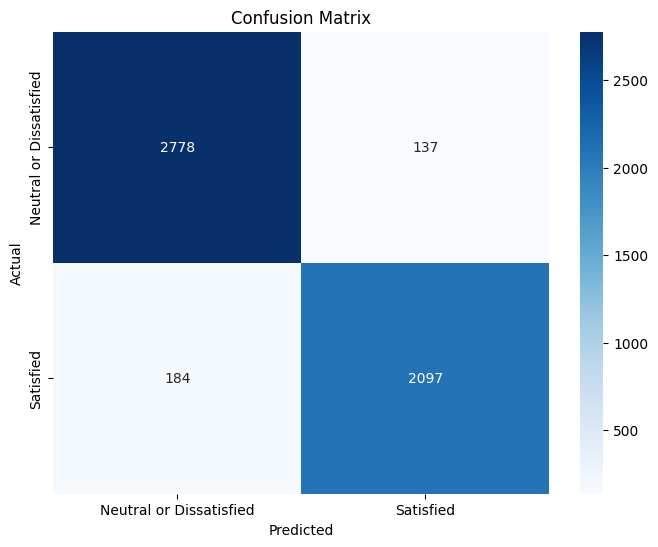

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

#Plot the confusion matrix (optional)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Neutral or Dissatisfied", "Satisfied"],
            yticklabels=["Neutral or Dissatisfied", "Satisfied"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


<style>
  .darkpop-heading {
    font-family: 'Consolas', monospace;
    background-color: #2d3748;
    color: #f0f0f0;
    padding: 10px 15px;
    border-radius: 4px;
    margin: 20px 0;
    font-size: 1.1em;
    font-weight: bold;
    border-bottom: 3px solid #f6ad55;
    letter-spacing: 0.5px;
  }
</style>

<h3 class="darkpop-heading">Pipeline Saving</h3>

In [18]:
# Saving the model
import pickle
with open("SVM_grid_search.pkl", "wb") as file:
    pickle.dump(grid_search, file)

In [19]:
from google.colab import files
files.download("SVM_grid_search.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>